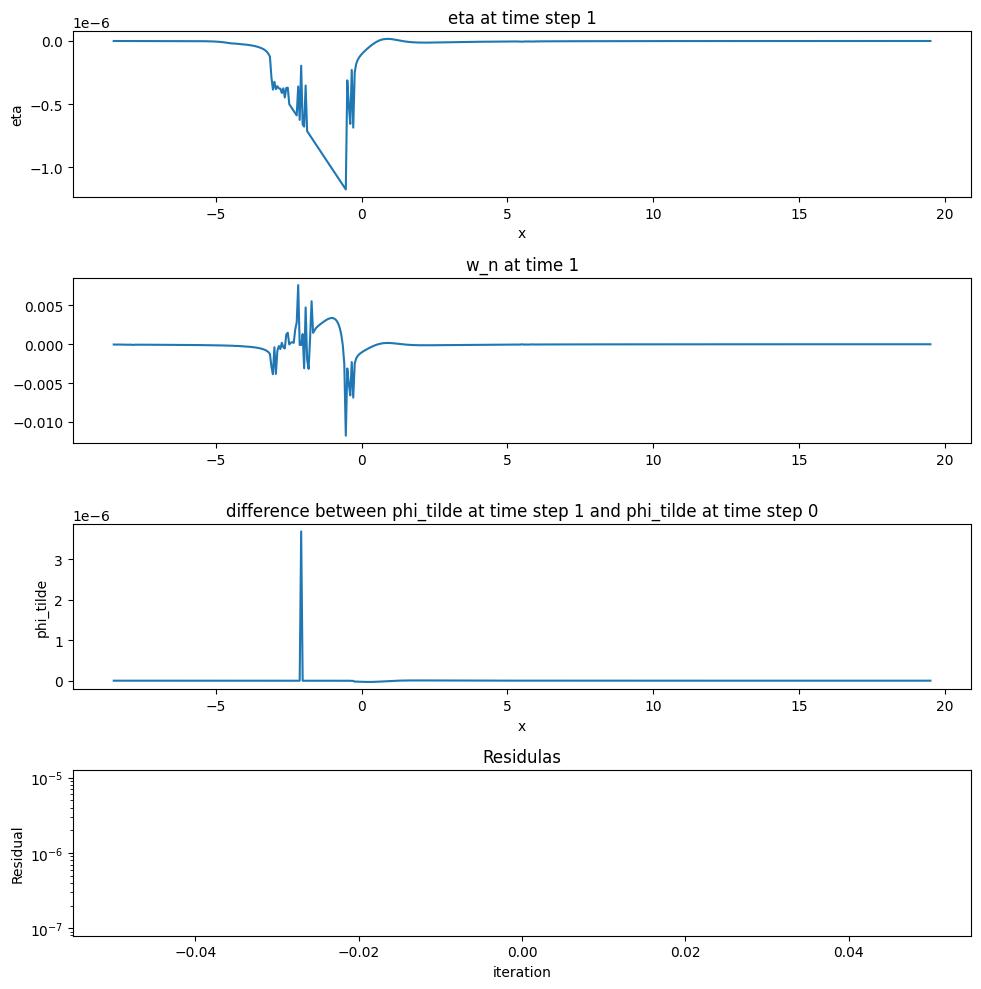

In [99]:
import matplotlib.pyplot as plt
import numpy as np

eta = np.load("./arrays/eta.npy")
phi = np.load("./arrays/phiTilde.npy")
fs_xs = np.load("./arrays/coordsFS.npy")
wn = np.load("./arrays/ws.npy")

# sorter informationen i alle numpy arrays
idx = np.argsort(fs_xs, axis=1)
eta = np.take_along_axis(eta, idx, axis=1)
phi = np.take_along_axis(phi, idx, axis=1)
fs_xs = np.take_along_axis(fs_xs, idx, axis=1)
wn = np.take_along_axis(wn, idx,axis = 1)

residuals = np.load("./arrays/residuals.npy")
residuals, time_step = residuals[:,0], residuals[:,1]

fig, ax = plt.subplots(4, 1, figsize = (10,10))
time = np.where(time_step == 0)[0][0] - 1
try:
    time = np.where(time_step == 0)[0][0] - 1
except:
    time = len(time_step) - 1

time = 1
height_of_FS = eta[0][0]
ax[0].plot(fs_xs[time][:], eta[time][:]-height_of_FS)
if time - 50 > 0:
    ax[0].plot(fs_xs[time-10][:], eta[time-10][:] - height_of_FS, alpha = 0.7, linestyle = "--")
    ax[0].plot(fs_xs[time-50][:], eta[time-50][:] - height_of_FS, alpha = 0.5, linestyle = "--")

ax[0].set_title(f"eta at time step {time}" )
ax[0].set_xlabel("x")
ax[0].set_ylabel("eta")

ax[1].plot(fs_xs[time][:], wn[time][:])
ax[1].set_title(f"w_n at time {time}")

init_phi = phi[0]
ax[2].plot(fs_xs[0], phi[time]-init_phi)
if time - 50 > 0:
    ax[2].plot(fs_xs[0], phi[time-10]-init_phi, alpha = 0.7, linestyle = "--")
    ax[2].plot(fs_xs[0], phi[time-50]-init_phi, alpha = 0.5, linestyle = "--")
ax[2].set_title(f"difference between phi_tilde at time step {time} and phi_tilde at time step 0" )
# ax[2].set_title(f"phi_tilde flattened at time step {time}")
ax[2].set_xlabel("x")
ax[2].set_ylabel("phi_tilde")
# ax[2].set_xlim(-3,0)
# ax[1].set_xlim(-3,0)

ax[3].plot(residuals[:time])
ax[3].set_title("Residulas")
ax[3].set_xlabel("iteration")
ax[3].set_ylabel("Residual")
ax[3].set_yscale("log")

plt.tight_layout()
plt.show()

In [95]:
eta[0] - height_of_FS

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
       -2.22044605e-16, -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
       -2.22044605e-16, -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
       -2.22044605e-16, -2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
       -4.44089210e-16, -

fig, ax = plt.subplots(1, 1, figsize = (14,6))
time = 0
x = np.linspace(fs_xs[0].min(), fs_xs[0].max(), 1000)
# ax.plot(fs_xs[0])
# ax.plot(x, np.sin(x* 2* np.pi/(8.5+20))/5 + 1.107008663883576 , linestyle = "--")
ax.plot(fs_xs[0],eta[0])
ax.set_title(f"fs_xs - etaNew, On NACA unordered NACA mesh, P = 3")
# ax.set_xlim(5,10)
plt.show()

In [96]:
fs_xs[0].max()

np.float64(19.5)

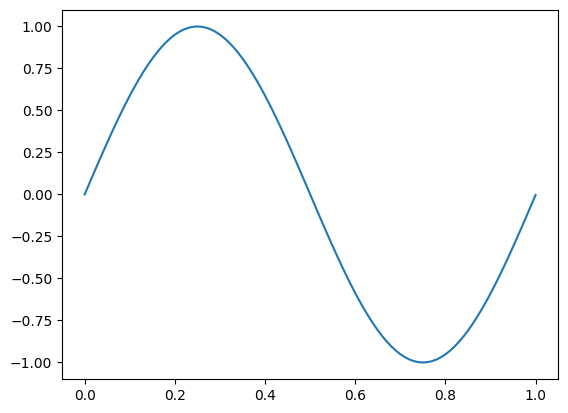

In [97]:
import firedrake as fd

P =3
mesh = fd.UnitSquareMesh(100, 100)
V = fd.FunctionSpace(mesh, "CG", P)
V1 = fd.FunctionSpace(mesh, "CG", 1)
fSIndecies = V.boundary_nodes(4)
coordsFS = (fd.Function(fd.VectorFunctionSpace(mesh, "CG", P)).interpolate(mesh.coordinates).dat.data)[fSIndecies,:]
fsMesh = fd.IntervalMesh(len(fSIndecies)-1, 0, 1)
fsMesh.coordinates.dat.data[:] = coordsFS[:,0]

Vfs = fd.FunctionSpace(fsMesh, "CG", 1)
eta = fd.Function(Vfs)
eta.dat.data[:] = coordsFS[:,1]

newEta = fd.Function(Vfs)
newEta.dat.data[:] = np.sin(2*3.14*coordsFS[:,0])

coords = mesh.coordinates.dat.data[:]
M = 0.5
coordsMask = coords[:, 1] > M

eta2d = np.interp(coords[coordsMask,0], fsMesh.coordinates.dat.data[:], eta.dat.data[:])
newEta2d = np.interp(coords[coordsMask,0], fsMesh.coordinates.dat.data[:], newEta.dat.data[:])

coords[coordsMask, 1] = M + (newEta2d - M)/(eta2d - M) * (coords[coordsMask, 1] - M)
mesh.coordinates.dat.data[:] = coords

plt.plot(coordsFS[::3,0], coords[V1.boundary_nodes(4), 1])
plt.show()